In [1]:

import pandas as pd
from ta.trend import EMAIndicator, macd, PSARIndicator
from ta.volatility import BollingerBands
from ta.momentum import rsi

def AddIndicators(df):
    df["MACD"] = macd(close=df["close"], window_slow=26, window_fast=12, fillna=True) # mazas
    df["RSI"] = rsi(close=df["close"], window=14, fillna=True)
    
    return df

In [2]:
class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        # define if show indicators
        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        # Create a new axis for indicatorswhich shares its x-axis with volume
        self.ax4 = self.ax2.twinx()
        
        self.sma7 = deque(maxlen=self.Render_range)
        self.sma25 = deque(maxlen=self.Render_range)
        self.sma99 = deque(maxlen=self.Render_range)
        
        self.bb_bbm = deque(maxlen=self.Render_range)
        self.bb_bbh = deque(maxlen=self.Render_range)
        self.bb_bbl = deque(maxlen=self.Render_range)
        
        self.psar = deque(maxlen=self.Render_range)

        self.MACD = deque(maxlen=self.Render_range)
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):
        self.sma7.append(df["sma7"])
        self.sma25.append(df["sma25"])
        self.sma99.append(df["sma99"])

        self.bb_bbm.append(df["bb_bbm"])
        self.bb_bbh.append(df["bb_bbh"])
        self.bb_bbl.append(df["bb_bbl"])

        self.psar.append(df["psar"])

        self.MACD.append(df["MACD"])
        self.RSI.append(df["RSI"])

        # Add Simple Moving Average
        self.ax1.plot(Date_Render_range, self.sma7,'-')
        self.ax1.plot(Date_Render_range, self.sma25,'-')
        self.ax1.plot(Date_Render_range, self.sma99,'-')

        # Add Bollinger Bands
        self.ax1.plot(Date_Render_range, self.bb_bbm,'-')
        self.ax1.plot(Date_Render_range, self.bb_bbh,'-')
        self.ax1.plot(Date_Render_range, self.bb_bbl,'-')

        # Add Parabolic Stop and Reverse
        self.ax1.plot(Date_Render_range, self.psar,'.')

        self.ax4.clear()
        # # Add Moving Average Convergence Divergence
        self.ax4.plot(Date_Render_range, self.MACD,'r-')

        # # Add Relative Strength Index
        self.ax4.plot(Date_Render_range, self.RSI,'g-')

    # Render the environment to the screen
    #def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
    def render(self, df, net_worth, trades):
        Date = df["Date"]
        Open = df["Open"]
        High = df["High"]
        Low = df["Low"]
        Close = df["Close"]
        Volume = df["Volume"]
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum


        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['Date'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['Low'] - RANGE*0.02
                    ycoords = trade['Low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['High'] + RANGE*0.02
                    ycoords = trade['High'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""

        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2.imshow("Bitcoin trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    # necessary convert to datetime
    df["Date"] = pd.to_datetime(df.Date)
    df["Date"] = df["Date"].apply(mpl_dates.date2num)

    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    
    # We are using the style ‘ggplot’
    plt.style.use('ggplot')
    
    # figsize attribute allows us to specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(16,8)) 

    # Create top subplot for price axis
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)

    # Create bottom subplot for volume which shares its x-axis
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    ax5 = plt.subplot2grid((6,1), (6,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('Price', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(rotation=45)

    # Add Simple Moving Average
    ax1.plot(df["Date"], df_original['sma7'],'-')
    ax1.plot(df["Date"], df_original['sma25'],'-')
    ax1.plot(df["Date"], df_original['sma99'],'-')

    # Add Bollinger Bands
    ax1.plot(df["Date"], df_original['bb_bbm'],'-')
    ax1.plot(df["Date"], df_original['bb_bbh'],'-')
    ax1.plot(df["Date"], df_original['bb_bbl'],'-')

    # Add Parabolic Stop and Reverse
    ax1.plot(df["Date"], df_original['psar'],'.')

    # # Add Moving Average Convergence Divergence
    ax2.plot(df["Date"], df_original['MACD'],'-')

    # # Add Relative Strength Index
    ax2.plot(df["Date"], df_original['RSI'],'-')

    # beautify the x-labels (Our Date format)
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))# %H:%M:%S'))
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [3]:
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
from datetime import datetime
import os
import cv2
import numpy as np

def Write_to_file(Date, net_worth, filename='{}.txt'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))):
    for i in net_worth: 
        Date += " {}".format(i)
    #print(Date)
    if not os.path.exists('logs'):
        os.makedirs('logs')
    file = open("logs/"+filename, 'a+')
    file.write(Date+"\n")
    file.close()

class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((7,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((7,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        self.ax5 = plt.subplot2grid((7,1), (6,0), rowspan=1, colspan=1, sharex=self.ax2)
        
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        # define if show indicators
        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        # Create a new axis for indicatorswhich shares its x-axis with volume
        
        self.ax4 = self.ax2.twinx()
        self.ema5 = deque(maxlen=self.Render_range)
        self.ema8 = deque(maxlen=self.Render_range)
        self.ema13 = deque(maxlen=self.Render_range)
        self.MACD = deque(maxlen=self.Render_range)
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):

        self.MACD.append(df["MACD"]*100)
        self.RSI.append(df["RSI"])
        self.ema5.append(df["ema5"])
        self.ema8.append(df["ema8"])
        self.ema13.append(df["ema13"])

        self.ax4.clear()
        # # Add Moving Average Convhergence Divergence
        self.ax5.plot(Date_Render_range, self.MACD,'r-')

        # # Add Relative Strength Index
        self.ax4.plot(Date_Render_range, self.RSI,'g-')

    # Render the environment to the screen
    #def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
    def render(self, df, net_worth, trades):
        Date = df["datetime"]
        Open = df["open"]
        High = df["high"]
        Low = df["low"]
        Close = df["close"]
        Volume = df["volume"]
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        Date = mpl_dates.date2num([pd.to_datetime(Date)])[0]
        self.render_data.append([Date, Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum


        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['datetime'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['low'] - RANGE*0.02
                    ycoords = trade['low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['high'] + RANGE*0.02
                    ycoords = trade['high'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('Date')
        self.ax1.set_ylabel('Price')
        self.ax3.set_ylabel('Balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""

        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2.imshow("trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    # necessary convert to datetime
    df["datetime"] = pd.to_datetime(df.Date)
    df["datetime"] = df["datetime"].apply(mpl_dates.date2num)

    df = df[['datetime', 'open', 'high', 'low', 'close', 'volume']]
    
    # We are using the style ‘ggplot’
    plt.style.use('ggplot')
    
    # figsize attribute allows us to specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(16,8)) 

    # Create top subplot for price axis
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)

    # Create bottom subplot for volume which shares its x-axis
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('Price', fontsize=12)
    plt.xlabel('Date')
    plt.xticks(rotation=45)

    # # Add Moving Average Convergence Divergence
    ax2.plot(df["datetime"], df_original['MACD']*100,'-')

    # # Add Relative Strength Index
    ax2.plot(df["datetime"], df_original['RSI'],'-')

    # beautify the x-labels (Our Date format)
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))#
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [58]:
class TradingGraph:
    # A crypto trading visualization using matplotlib made to render custom prices which come in following way:
    # Date, Open, High, Low, Close, Volume, net_worth, trades
    # call render every step
    def __init__(self, Render_range, Show_reward=False, Show_indicators=False):
        self.Volume = deque(maxlen=Render_range)
        self.net_worth = deque(maxlen=Render_range)
        self.render_data = deque(maxlen=Render_range)
        self.Render_range = Render_range
        self.Show_reward = Show_reward
        self.Show_indicators = Show_indicators

        # We are using the style ‘ggplot’
        plt.style.use('ggplot')
        # close all plots if there are open
        plt.close('all')
        # figsize attribute allows us to specify the width and height of a figure in unit inches
        self.fig = plt.figure(figsize=(16,8)) 

        # Create top subplot for price axis
        self.ax1 = plt.subplot2grid((7,1), (0,0), rowspan=5, colspan=1)
        
        # Create bottom subplot for volume which shares its x-axis
        self.ax2 = plt.subplot2grid((7,1), (5,0), rowspan=1, colspan=1, sharex=self.ax1)
        self.ax5 = plt.subplot2grid((7,1), (6,0), rowspan=1, colspan=1, sharex=self.ax1)
        
        # Create a new axis for net worth which shares its x-axis with price
        self.ax3 = self.ax1.twinx()

        # Formatting Date
        self.date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        
        # Add paddings to make graph easier to view
        #plt.subplots_adjust(left=0.07, bottom=-0.1, right=0.93, top=0.97, wspace=0, hspace=0)

        # define if show indicators
        if self.Show_indicators:
            self.Create_indicators_lists()

    def Create_indicators_lists(self):
        # Create a new axis for indicatorswhich shares its x-axis with volume
        self.ax4 = self.ax2.twinx()
        
        self.ema5 = deque(maxlen=self.Render_range)
        self.ema8 = deque(maxlen=self.Render_range)
        self.ema13 = deque(maxlen=self.Render_range)

        self.MACD = deque(maxlen=self.Render_range)
        self.RSI = deque(maxlen=self.Render_range)


    def Plot_indicators(self, df, Date_Render_range):
        
        self.ema5.append(df["ema5"])
        self.ema8.append(df["ema8"])
        self.ema13.append(df["ema13"])
        
        self.MACD.append(df["MACD"])
        self.RSI.append(df["RSI"])

        self.ax4.clear()
        self.ax5.clear()
        # # Add Moving Average Convergence Divergence
        self.ax5.plot(Date_Render_range, self.MACD,'r-')

        # # Add Relative Strength Index
        self.ax4.plot(Date_Render_range, self.RSI,'g-')

    # Render the environment to the screen
    #def render(self, Date, Open, High, Low, Close, Volume, net_worth, trades):
    def render(self, df, net_worth, trades):
        Open = df["open"]
        High = df["high"]
        Low = df["low"]
        Close = df["close"]
        Volume = df["volume"]
        # append volume and net_worth to deque list
        self.Volume.append(Volume)
        self.net_worth.append(net_worth)

        # before appending to deque list, need to convert Date to special format
        self.render_data.append([Open, High, Low, Close])
        
        # Clear the frame rendered last step
        self.ax1.clear()
        candlestick_ohlc(self.ax1, self.render_data, width=0.8/24, colorup='green', colordown='red', alpha=0.8)

        # Put all dates to one list and fill ax2 sublot with volume
        Date_Render_range = [i[0] for i in self.render_data]
        self.ax2.clear()
        self.ax2.fill_between(Date_Render_range, self.Volume, 0)

        if self.Show_indicators:
            self.Plot_indicators(df, Date_Render_range)

        # draw our net_worth graph on ax3 (shared with ax1) subplot
        self.ax3.clear()
        self.ax3.plot(Date_Render_range, self.net_worth, color="blue")
        
        # beautify the x-labels (Our Date format)
        self.ax1.xaxis.set_major_formatter(self.date_format)
        self.fig.autofmt_xdate()

        minimum = np.min(np.array(self.render_data)[:,1:])
        maximum = np.max(np.array(self.render_data)[:,1:])
        RANGE = maximum - minimum


        # sort sell and buy orders, put arrows in appropiate order positions
        for trade in trades:
            trade_date = mpl_dates.date2num([pd.to_datetime(trade['datetime'])])[0]
            if trade_date in Date_Render_range:
                if trade['type'] == 'buy':
                    high_low = trade['low'] - RANGE*0.02
                    ycoords = trade['low'] - RANGE*0.08
                    self.ax1.scatter(trade_date, high_low, c='green', label='green', s = 120, edgecolors='none', marker="^")
                else:
                    high_low = trade['high'] + RANGE*0.02
                    ycoords = trade['high'] + RANGE*0.06
                    self.ax1.scatter(trade_date, high_low, c='red', label='red', s = 120, edgecolors='none', marker="v")

                if self.Show_reward:
                    try:
                        self.ax1.annotate('{0:.2f}'.format(trade['Reward']), (trade_date-0.02, high_low), xytext=(trade_date-0.02, ycoords),
                                                   bbox=dict(boxstyle='round', fc='w', ec='k', lw=1), fontsize="small")
                    except:
                        pass

        # we need to set layers every step, because we are clearing subplots every step
        self.ax2.set_xlabel('datetime')
        self.ax1.set_ylabel('price')
        self.ax3.set_ylabel('balance')

        # I use tight_layout to replace plt.subplots_adjust
        self.fig.tight_layout()

        """Display image with matplotlib - interrupting other tasks"""
        # Show the graph without blocking the rest of the program
        #plt.show(block=False)
        # Necessary to view frames before they are unrendered
        #plt.pause(0.001)

        """Display image with OpenCV - no interruption"""

        # redraw the canvas
        self.fig.canvas.draw()
        # convert canvas to image
        img = np.fromstring(self.fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        img  = img.reshape(self.fig.canvas.get_width_height()[::-1] + (3,))
        
        # img is rgb, convert to opencv's default bgr
        image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        # display image with OpenCV or any operation you like
        cv2.imshow("trading bot",image)

        if cv2.waitKey(25) & 0xFF == ord("q"):
            cv2.destroyAllWindows()
            return
        else:
            return img
        

def Plot_OHCL(df):
    df_original = df.copy()
    
    # We are using the style ‘ggplot’
    plt.style.use('ggplot')
    
    # figsize attribute allows us to specify the width and height of a figure in unit inches
    fig = plt.figure(figsize=(16,8)) 

    # Create top subplot for price axis
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)

    # Create bottom subplot for volume which shares its x-axis
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

    candlestick_ohlc(ax1, df.values, width=0.8/24, colorup='green', colordown='red', alpha=0.8)
    ax1.set_ylabel('price', fontsize=12)
    plt.xlabel('datetime')
    plt.xticks(rotation=45)

    # # Add Moving Average Convergence Divergence
    ax2.plot(df_original['MACD'],'-')

    # # Add Relative Strength Index
    ax2.plot(df_original['RSI'],'-')

    # beautify the x-labels (Our Date format)
    ax1.xaxis.set_major_formatter(mpl_dates.DateFormatter('%y-%m-%d'))# %H:%M:%S'))
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.show()

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import backend as K
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

class Shared_Model:
    def __init__(self, input_shape, action_space, lr, optimizer, model="Dense"):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten()(X_input)
        X = Dense(512, activation="relu")(X)
        
        # Critic model
        V = Dense(512, activation="relu")(X)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

        # Actor model
        A = Dense(512, activation="relu")(X)
        A = Dense(256, activation="relu")(A)
        A = Dense(64, activation="relu")(A)
        output = Dense(self.action_space, activation="softmax")(A)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))

    def ppo_loss(self, y_true, y_pred):

        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

        
class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space

        X = Flatten(input_shape=input_shape)(X_input)
        X = Dense(512, activation="relu")(X)
        X = Dense(256, activation="relu")(X)
        X = Dense(64, activation="relu")(X)
        output = Dense(self.action_space, activation="softmax")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss, optimizer=optimizer(lr=lr))
        #print(self.Actor.summary)

    def ppo_loss(self, y_true, y_pred):
        # Defined in https://arxiv.org/abs/1707.06347
        advantages, prediction_picks, actions = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space:]
        LOSS_CLIPPING = 0.2
        ENTROPY_LOSS = 0.001
        
        prob = actions * y_pred
        old_prob = actions * prediction_picks

        prob = K.clip(prob, 1e-10, 1.0)
        old_prob = K.clip(old_prob, 1e-10, 1.0)

        ratio = K.exp(K.log(prob) - K.log(old_prob))
        
        p1 = ratio * advantages
        p2 = K.clip(ratio, min_value=1 - LOSS_CLIPPING, max_value=1 + LOSS_CLIPPING) * advantages

        actor_loss = -K.mean(K.minimum(p1, p2))

        entropy = -(y_pred * K.log(y_pred + 1e-10))
        entropy = ENTROPY_LOSS * K.mean(entropy)
        
        total_loss = actor_loss - entropy

        return total_loss

    def actor_predict(self, state):
        return self.Actor.predict(state)

class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)

        V = Flatten(input_shape=input_shape)(X_input)
        V = Dense(512, activation="relu")(V)
        V = Dense(256, activation="relu")(V)
        V = Dense(64, activation="relu")(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=X_input, outputs = value)
        self.Critic.compile(loss=self.critic_PPO2_loss, optimizer=optimizer(lr=lr))

    def critic_PPO2_loss(self, y_true, y_pred):
        value_loss = K.mean((y_true - y_pred) ** 2) # standard PPO loss
        return value_loss

    def critic_predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import copy
import pandas as pd
import numpy as np
import random
from collections import deque
from tensorboardX import SummaryWriter
from tensorflow.keras.optimizers.legacy import Adam, RMSprop
import matplotlib.pyplot as plt
from datetime import datetime

class CustomAgent:
    # A custom Bitcoin trading agent
    def __init__(self, lookback_window_size=50, lr=0.00005, epochs=1, optimizer=Adam, batch_size=32, model=""):
        self.lookback_window_size = lookback_window_size
        self.model = model
        
        # Action space from 0 to 3, 0 is hold, 1 is buy, 2 is sell
        self.action_space = np.array([0, 1, 2])

        # folder to save models
        self.log_name = datetime.now().strftime("%Y_%m_%d_%H_%M")+"_trader"
        
        # State size contains Market+Orders history for the last lookback_window_size steps
        #self.state_size = (lookback_window_size, 10)
        self.state_size = (lookback_window_size, 10+5) # 10 standard information +9 indicators

        # Neural Networks part bellow
        self.lr = lr
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size

        # Create shared Actor-Critic network model
        self.Actor = self.Critic = Shared_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer, model=self.model)
        # Create Actor-Critic network model
        #self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        #self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_space.shape[0], lr=self.lr, optimizer = self.optimizer)
        
    # create tensorboard writer
    def create_writer(self, initial_balance, normalize_value, train_episodes):
        self.replay_count = 0
        self.writer = SummaryWriter('runs/'+self.log_name)

        # Create folder to save models
        if not os.path.exists(self.log_name):
            os.makedirs(self.log_name)

        self.start_training_log(initial_balance, normalize_value, train_episodes)
            
    def start_training_log(self, initial_balance, normalize_value, train_episodes):      
        # save training parameters to Parameters.txt file for future
        with open(self.log_name+"/Parameters.txt", "w") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training start: {current_date}\n")
            params.write(f"initial_balance: {initial_balance}\n")
            params.write(f"training episodes: {train_episodes}\n")
            params.write(f"lookback_window_size: {self.lookback_window_size}\n")
            params.write(f"lr: {self.lr}\n")
            params.write(f"epochs: {self.epochs}\n")
            params.write(f"batch size: {self.batch_size}\n")
            params.write(f"normalize_value: {normalize_value}\n")
            params.write(f"model: {self.model}\n")
            
    def end_training_log(self):
        with open(self.log_name+"/Parameters.txt", "a+") as params:
            current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
            params.write(f"training end: {current_date}\n")

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.95, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, predictions, dones, next_states):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        predictions = np.vstack(predictions)

        # Get Critic network predictions 
        values = self.Critic.critic_predict(states)
        next_values = self.Critic.critic_predict(next_states)
        
        # Compute advantages
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        # stack everything to numpy array
        y_true = np.hstack([advantages, predictions, actions])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)
        c_loss = self.Critic.Critic.fit(states, target, epochs=self.epochs, verbose=0, shuffle=True, batch_size=self.batch_size)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.replay_count += 1

        return np.sum(a_loss.history['loss']), np.sum(c_loss.history['loss'])

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        prediction = self.Actor.actor_predict(np.expand_dims(state, axis=0))[0]
        action = np.random.choice(self.action_space, p=prediction)
        return action, prediction
        
    def save(self, name="trader", score="", args=[]):
        # save keras model weights
        self.Actor.Actor.save_weights(f"{self.log_name}/{score}_{name}_Actor.h5")
        self.Critic.Critic.save_weights(f"{self.log_name}/{score}_{name}_Critic.h5")

        # log saved model arguments to file
        if len(args) > 0:
            with open(f"{self.log_name}/log.txt", "a+") as log:
                current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                atgumets = ""
                for arg in args:
                    atgumets += f", {arg}"
                log.write(f"{current_time}{atgumets}\n")

    def load(self, folder, name):
        # load keras model weights
        self.Actor.Actor.load_weights(os.path.join(folder, f"{name}_Actor.h5"))
        self.Critic.Critic.load_weights(os.path.join(folder, f"{name}_Critic.h5"))

        
class CustomEnv:
    # A custom Bitcoin trading environment
    def __init__(self, df, initial_balance=1000, lookback_window_size=50, Render_range=100, Show_reward=False, Show_indicators=False, normalize_value=40000):
        # Define action space and state size and other custom parameters
        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_balance = initial_balance
        self.lookback_window_size = lookback_window_size
        self.Render_range = Render_range # render range in visualization
        self.Show_reward = Show_reward # show order reward in rendered visualization
        self.Show_indicators = Show_indicators # show main indicators in rendered visualization

        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.lookback_window_size)
        
        # Market history contains the OHCL values for the last lookback_window_size prices
        self.market_history = deque(maxlen=self.lookback_window_size)

        self.indicators_history = deque(maxlen=self.lookback_window_size)

        self.normalize_value = normalize_value

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size = 0):
        self.visualization = TradingGraph(Render_range=self.Render_range, Show_reward=self.Show_reward, Show_indicators=self.Show_indicators) # init visualization
        self.trades = deque(maxlen=self.Render_range) # limited orders memory for visualization
        
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.held = 0
        self.sold = 0
        self.bought = 0
        self.episode_orders = 0 # track episode orders count
        self.prev_episode_orders = 0 # track previous episode orders count
        self.rewards = deque(maxlen=self.Render_range)
        self.env_steps_size = env_steps_size
        self.punish_value = 0
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(self.lookback_window_size, self.df_total_steps - env_steps_size)
            self.end_step = self.start_step + env_steps_size
        else: # used for testing dataset
            self.start_step = self.lookback_window_size
            self.end_step = self.df_total_steps
            
        self.current_step = self.start_step

        for i in reversed(range(self.lookback_window_size)):
            current_step = self.current_step - i
            self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

            self.market_history.append([self.df.loc[current_step, 'open'],
                                        self.df.loc[current_step, 'high'],
                                        self.df.loc[current_step, 'low'],
                                        self.df.loc[current_step, 'close'],
                                        self.df.loc[current_step, 'volume'],
                                        ])

            self.indicators_history.append([self.df.loc[current_step, 'ema5'],
                                            self.df.loc[current_step, 'ema8'],
                                            self.df.loc[current_step, 'ema13'],
                                        self.df.loc[current_step, 'MACD'] / 400,
                                        self.df.loc[current_step, 'RSI'] / 100
                                        ])
            

        state = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        state = np.concatenate((state, self.indicators_history), axis=1)

        return state

    # Get the data points for the given current_step
    def _next_observation(self):
        self.market_history.append([self.df.loc[self.current_step, 'open'],
                                    self.df.loc[self.current_step, 'high'],
                                    self.df.loc[self.current_step, 'low'],
                                    self.df.loc[self.current_step, 'close'],
                                    self.df.loc[self.current_step, 'volume'],
                                    ])

        self.indicators_history.append([self.df.loc[self.current_step, 'ema5'],
                                        self.df.loc[self.current_step, 'ema8'],
                                        self.df.loc[self.current_step, 'ema13'],
                                    self.df.loc[self.current_step, 'MACD'] / 400,
                                    self.df.loc[self.current_step, 'RSI'] / 100
                                    ])
        
        obs = np.concatenate((self.market_history, self.orders_history), axis=1) / self.normalize_value
        obs = np.concatenate((obs, self.indicators_history), axis=1)
        
        return obs

    # Execute one time step within the environment
    def step(self, action):
        self.bought = 0
        self.sold = 0
        self.current_step += 1

        # Set the current price to a random price between open and close
        #current_price = random.uniform(
        #    self.df.loc[self.current_step, 'Open'],
        #    self.df.loc[self.current_step, 'Close'])
        current_price = self.df.loc[self.current_step, 'open']
        Date = self.df.loc[self.current_step, 'datetime'] # for visualization
        High = self.df.loc[self.current_step, 'high'] # for visualization
        Low = self.df.loc[self.current_step, 'low'] # for visualization

        if action == 0: # Hold
            pass

        elif action == 1 and self.balance > self.initial_balance/100:
            # Buy with 100% of current balance
            self.bought = self.balance / current_price
            self.balance -= self.bought * current_price
            self.held += self.bought
            self.trades.append({'datetime' : Date, 'high' : High, 'low' : Low, 'total': self.bought, 'type': "buy", 'current_price': current_price})
            self.episode_orders += 1

        elif action == 2 and self.held>0:
            # Sell 100% of current crypto held
            self.sold = self.held
            self.balance += self.sold * current_price
            self.held -= self.sold
            self.trades.append({'datetime' : Date, 'high' : High, 'low' : Low, 'total': self.sold, 'type': "sell", 'current_price': current_price})
            self.episode_orders += 1

        self.prev_net_worth = self.net_worth
        self.net_worth = self.balance + self.held * current_price

        self.orders_history.append([self.balance, self.net_worth, self.bought, self.sold, self.held])

        # Receive calculated reward
        reward = self.get_reward()

        if self.net_worth <= self.initial_balance/2:
            done = True
        else:
            done = False

        obs = self._next_observation()
        
        return obs, reward, done

    # Calculate reward
    def get_reward(self):
        self.punish_value += self.net_worth * 0.00001
        if self.episode_orders > 1 and self.episode_orders > self.prev_episode_orders:
            self.prev_episode_orders = self.episode_orders
            if self.trades[-1]['type'] == "buy" and self.trades[-2]['type'] == "sell":
                reward = self.trades[-2]['total']*self.trades[-2]['current_price'] - self.trades[-2]['total']*self.trades[-1]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
            elif self.trades[-1]['type'] == "sell" and self.trades[-2]['type'] == "buy":
                reward = self.trades[-1]['total']*self.trades[-1]['current_price'] - self.trades[-2]['total']*self.trades[-2]['current_price']
                reward -= self.punish_value
                self.punish_value = 0
                self.trades[-1]["Reward"] = reward
                return reward
        else:
            return 0 - self.punish_value

    # render environment
    def render(self, visualize = False):
        #print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')
        if visualize:
            # Render the environment to the screen
            img = self.visualization.render(self.df.loc[self.current_step], self.net_worth, self.trades)
            return img

        
def Random_games(env, visualize, test_episodes = 50, comment=""):
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action = np.random.randint(3, size=1)[0]
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1 # calculate episode count where we had negative profit through episode
                print("episode: {}, net_worth: {}, average_net_worth: {}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break

    print("average {} episodes random net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {"Random games"}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, comment: {comment}\n')

def train_agent(env, agent, visualize=False, train_episodes = 50, training_batch_size=500):
    agent.create_writer(env.initial_balance, env.normalize_value, train_episodes) # create TensorBoard writer
    total_average = deque(maxlen=100) # save recent 100 episodes net worth
    best_average = 0 # used to track best average net worth
    for episode in range(train_episodes):
        state = env.reset(env_steps_size = training_batch_size)

        states, actions, rewards, predictions, dones, next_states = [], [], [], [], [], []
        for t in range(training_batch_size):
            env.render(visualize)
            action, prediction = agent.act(state)
            next_state, reward, done = env.step(action)
            states.append(np.expand_dims(state, axis=0))
            next_states.append(np.expand_dims(next_state, axis=0))
            action_onehot = np.zeros(3)
            action_onehot[action] = 1
            actions.append(action_onehot)
            rewards.append(reward)
            dones.append(done)
            predictions.append(prediction)
            state = next_state

        a_loss, c_loss = agent.replay(states, actions, rewards, predictions, dones, next_states)
        total_average.append(env.net_worth)
        average = np.average(total_average)
        
        agent.writer.add_scalar('Data/average net_worth', average, episode)
        agent.writer.add_scalar('Data/episode_orders', env.episode_orders, episode)
        
        print("episode: {:<5} net worth {:<7.2f} average: {:<7.2f} orders: {}".format(episode, env.net_worth, average, env.episode_orders))
        if episode > len(total_average):
            if best_average < average:
                best_average = average
                print("Saving model")
                agent.save(score="{:.2f}".format(best_average), args=[episode, average, env.episode_orders, a_loss, c_loss])
            agent.save()
            
    agent.end_training_log()
    
def test_agent(env, agent, visualize=True, test_episodes=10, folder="", name="_trader", comment=""):
    agent.load(folder, name)
    average_net_worth = 0
    average_orders = 0
    no_profit_episodes = 0
    for episode in range(test_episodes):
        state = env.reset()
        while True:
            env.render(visualize)
            action, prediction = agent.act(state)
            state, reward, done = env.step(action)
            if env.current_step == env.end_step:
                average_net_worth += env.net_worth
                average_orders += env.episode_orders
                if env.net_worth < env.initial_balance: no_profit_episodes += 1
                print("episode: {:<5}, net_worth: {:<7.2f}, average_net_worth: {:<7.2f}, orders: {}".format(episode, env.net_worth, average_net_worth/(episode+1), env.episode_orders))
                break
            
    print("average {} episodes agent net_worth: {}, orders: {}".format(test_episodes, average_net_worth/test_episodes, average_orders/test_episodes))
    print("No profit episodes: {}".format(no_profit_episodes))
    # save test results to test_results.txt file
    with open("test_results.txt", "a+") as results:
        current_date = datetime.now().strftime('%Y-%m-%d %H:%M')
        results.write(f'{current_date}, {name}, test episodes:{test_episodes}')
        results.write(f', net worth:{average_net_worth/(episode+1)}, orders per episode:{average_orders/test_episodes}')
        results.write(f', no profit episodes:{no_profit_episodes}, model: {agent.model}, comment: {comment}\n')




In [116]:
from tvDatafeed import TvDatafeed, Interval

username = 'No_Sock'
password = '#TradeCore$23'
tv = TvDatafeed(username, password)
pfe_data = tv.get_hist(symbol='PFE',exchange='NYSE',interval=Interval.in_1_hour,n_bars=10000)


df = pfe_data[['open','high','low','close','volume']].reset_index()
df = AddIndicators(df)

In [6]:
ddf = pd.read_csv('pfedata.csv')[['datetime','open','high','low','close','volume','MACD','RSI','ema5','ema8','ema13']]

In [37]:
ddf = df[['datetime','open','high','low','close','volume','MACD','RSI']]

0      2020-01-02 17:30:00
1      2020-01-02 18:30:00
2      2020-01-02 19:30:00
3      2020-01-02 20:30:00
4      2020-01-02 21:30:00
               ...        
5858   2023-05-01 21:30:00
5859   2023-05-01 22:30:00
5860   2023-05-02 16:30:00
5861   2023-05-02 17:30:00
5862   2023-05-02 18:30:00
Name: datetime, Length: 5863, dtype: datetime64[ns]

In [49]:
load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
reload_ext tensorboard

In [7]:
tensorboard --logdir=runs/ --port=8080

In [7]:

lookback_window_size = 50
test_window = 805
train_df = ddf[:-test_window-lookback_window_size]
test_df = ddf[-test_window-lookback_window_size:]
agent = CustomAgent(lookback_window_size=lookback_window_size, lr=0.00001, epochs=5, optimizer=Adam, batch_size = 32, model="Dense")

C:\Users\ThinkPadX4\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
test_df['datetime'] = pd.date_range(start = "2022-11-21 18:30:00", periods = 855, freq='H')

C:\Users\ThinkPadX4\AppData\Local\Temp\ipykernel_13428\1364660045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['datetime'] = pd.date_range(start = "2022-11-21 18:30:00", periods = 855, freq='H')


In [9]:
test_df = test_df.iloc[:350]

In [10]:
test_df

,datetime,open,high,low,close,volume,MACD,RSI,ema5,ema8,ema13
5000,2022-11-21 18:30:00,48.010,48.080,47.855,48.010,164095.0,0.456151,67.239274,47.874715,47.732564,47.535662
5001,2022-11-21 19:30:00,47.810,48.090,47.220,47.310,173494.0,0.401467,53.323618,47.686477,47.638661,47.503425
5002,2022-11-21 20:30:00,47.320,47.445,47.195,47.350,95036.0,0.357240,53.910604,47.574318,47.574514,47.481507
5003,2022-11-21 21:30:00,47.340,47.410,47.045,47.045,50356.0,0.294187,48.864575,47.397878,47.456844,47.419149
5004,2022-11-21 22:30:00,47.045,47.270,46.960,47.230,75199.0,0.256192,51.810902,47.341919,47.406434,47.392127
...,...,...,...,...,...,...,...,...,...,...,...
5345,2022-12-06 03:30:00,48.010,48.010,47.860,47.910,44387.0,-0.193203,49.365265,47.869966,47.782080,47.717245
5346,2022-12-06 04:30:00,47.910,48.025,47.850,47.890,47858.0,-0.165421,48.941638,47.876644,47.806062,47.741924
5347,2022-12-06 05:30:00,47.885,48.020,47.800,47.870,127696.0,-0.143365,48.493482,47.874430,47.820270,47.760221
5348,2022-12-06 06:30:00,47.865,47.980,47.805,47.850,95091.0,-0.126046,48.019941,47.866286,47.826877,47.773046


In [51]:
pd.date_range(start = "2022-11-21 18:30:00", periods = 770, freq='H')

DatetimeIndex(['2022-11-21 18:30:00', '2022-11-21 19:30:00',
               '2022-11-21 20:30:00', '2022-11-21 21:30:00',
               '2022-11-21 22:30:00', '2022-11-21 23:30:00',
               '2022-11-22 00:30:00', '2022-11-22 01:30:00',
               '2022-11-22 02:30:00', '2022-11-22 03:30:00',
               ...
               '2022-12-23 10:30:00', '2022-12-23 11:30:00',
               '2022-12-23 12:30:00', '2022-12-23 13:30:00',
               '2022-12-23 14:30:00', '2022-12-23 15:30:00',
               '2022-12-23 16:30:00', '2022-12-23 17:30:00',
               '2022-12-23 18:30:00', '2022-12-23 19:30:00'],
              dtype='datetime64[ns]', length=770, freq='H')

In [11]:
test_df

,datetime,open,high,low,close,volume,MACD,RSI,ema5,ema8,ema13
5000,2022-11-21 18:30:00,48.010,48.080,47.855,48.010,164095.0,0.456151,67.239274,47.874715,47.732564,47.535662
5001,2022-11-21 19:30:00,47.810,48.090,47.220,47.310,173494.0,0.401467,53.323618,47.686477,47.638661,47.503425
5002,2022-11-21 20:30:00,47.320,47.445,47.195,47.350,95036.0,0.357240,53.910604,47.574318,47.574514,47.481507
5003,2022-11-21 21:30:00,47.340,47.410,47.045,47.045,50356.0,0.294187,48.864575,47.397878,47.456844,47.419149
5004,2022-11-21 22:30:00,47.045,47.270,46.960,47.230,75199.0,0.256192,51.810902,47.341919,47.406434,47.392127
...,...,...,...,...,...,...,...,...,...,...,...
5345,2022-12-06 03:30:00,48.010,48.010,47.860,47.910,44387.0,-0.193203,49.365265,47.869966,47.782080,47.717245
5346,2022-12-06 04:30:00,47.910,48.025,47.850,47.890,47858.0,-0.165421,48.941638,47.876644,47.806062,47.741924
5347,2022-12-06 05:30:00,47.885,48.020,47.800,47.870,127696.0,-0.143365,48.493482,47.874430,47.820270,47.760221
5348,2022-12-06 06:30:00,47.865,47.980,47.805,47.850,95091.0,-0.126046,48.019941,47.866286,47.826877,47.773046


IndexError: GridSpec slice would result in no space allocated for subplot

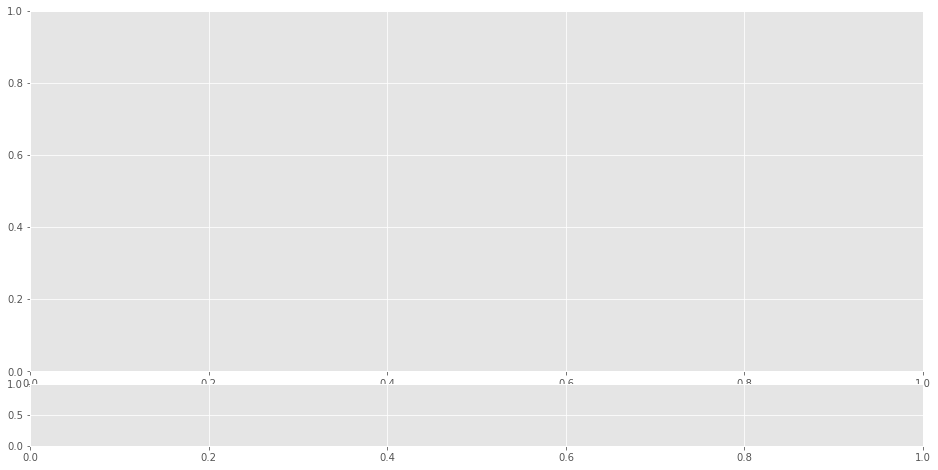

In [57]:
train_env = CustomEnv(train_df, lookback_window_size=lookback_window_size)
train_agent(train_env, agent, visualize=False, train_episodes=100, training_batch_size=500)

episode: 0    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 1    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 2    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 3    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 4    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 5    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 6    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 7    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 8    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 9    , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 10   , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 11   , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 12   , net_worth: 1000.00, average_net_worth: 1000.00, orders: 0
episode: 13   , net_worth: 1000.00, av

KeyboardInterrupt: 

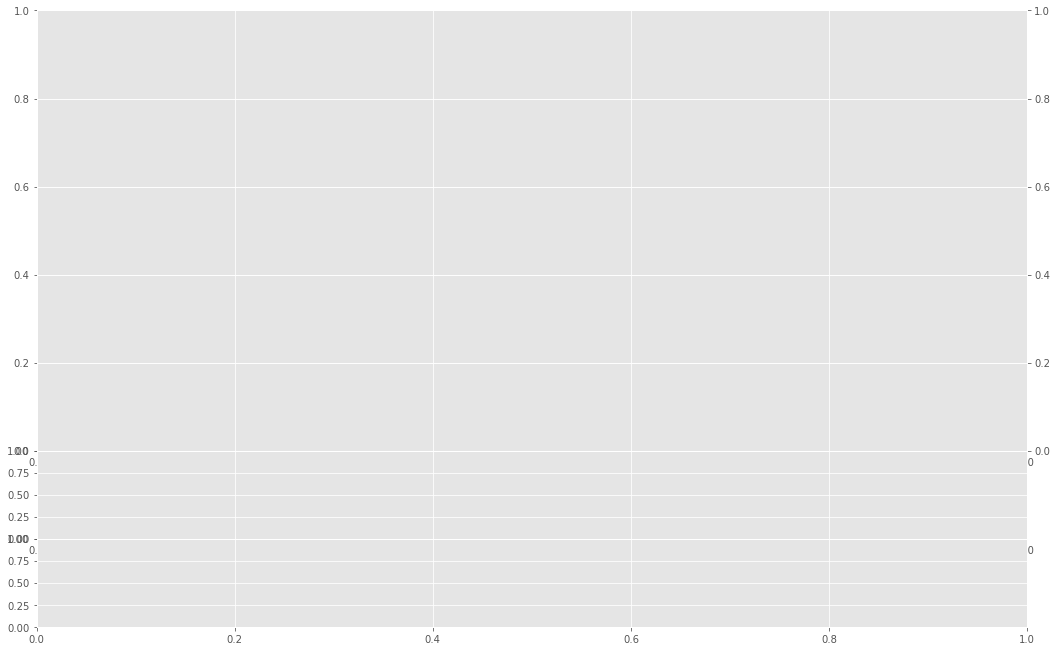

In [13]:
test_env = CustomEnv(test_df, lookback_window_size=lookback_window_size, Show_reward=False, Show_indicators=False)
test_agent(test_env, agent, visualize=False, test_episodes=100, folder="Big", name="2635.74_trader", comment="")

In [17]:
pd.Series(df.index)

0          0
1          1
2          2
3          3
4          4
        ... 
5858    5858
5859    5859
5860    5860
5861    5861
5862    5862
Length: 5863, dtype: int64